# 1# Imports



In [155]:
# Imports des bibliothèques classiques
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook
tqdm_notebook().pandas()
from tqdm import tqdm

from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

# "lemmatizer" = FRENCH Tokenizer AND Lemmatizer (from spacy)
import fr_core_news_md
lemmatizer = fr_core_news_md.load()

# Imports nécessaires pour LDA
from gensim import models
from gensim.models import Phrases
from gensim import corpora

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [156]:
### ANCIENNE TECHNIQUE D'IMPORT de "lemmatizer" --> NECESSITE DE RESTART LE RUNTIME ENV...
# !pip install spacy
# !python -m spacy download fr_core_news_md
# import spacy
# lemmatizer = spacy.load('fr_core_news_md')

# 2# Load data

In [157]:
def get_dataframe(file_name,lower=False,to_spaces=[]):
    """ Charge la base de données dans une dataframe python en effectuant un pré-traitement de base :
        - suppression des lignes vides
        - suppression des sauts de lignes et indentations dans les resumes 
        to_spaces permet de préciser quels autres séquences doivent être remplacées par des espaces dans le texte."""
    input_df = pd.read_excel(file_name)
    df = input_df[["EAN","Description sans html"]]
    df.columns = ['EAN','textes']
    # Suppression des lignes vides
    df = df.dropna().reset_index(drop=True)
    # Suppression des sauts de lignes et indentations dans les resumes
    for k in range(0,df.shape[0]):
        for elt in to_spaces:
            df.iloc[k,1] = df.iloc[k,1].replace(elt," ")
        if lower:
            df.iloc[k,1] = df.iloc[k,1].lower()
    print('Dataframe with shape {1} loaded from "{0}"\n'.format(file_name,df.shape))
    return(df)

In [158]:
data = get_dataframe('corpus 1.xlsx', lower=True, to_spaces=["\n","\t","&nbsp;"])
print(data['textes'].head())

Dataframe with shape (1536, 2) loaded from "corpus 1.xlsx"

0    si nous connaissons pierre-gilles de gennes de...
1    exploration des mondes sous-marins, conquêtes ...
2    langage parlé, cinéma, chanson, publicité et, ...
3    dans la cellule de la prison où l'avait enferm...
4    siyu cao est d’abord un regard. un regard brid...
Name: textes, dtype: object


# 3# Load stopwords

In [183]:
# stopwords spéciaux propres au corpus
special_stopwords = set(['',' ','  ','nbsp','pa','faire','al','politique','pouvoir','histoire','homme','monde','grand','ouvrage','livre','nouveau'])
## Transformations étranges du lemmatizer
# aux -> al
# aujourd'hui -> (aujourd',hui)

In [184]:
# stopwords francais & stopsymbols
f = open('stop_words_french.txt') ; fr_stopwords = set(f.read().split('\n')) ; f.close() ; print("NB french stopwords : ",len(fr_stopwords))
f = open('stop_symbols.txt') ; stopsymbols = set(f.read().split('\n')) ; f.close() ; print("NB stopsymbols : ",len(stopsymbols))
print("NB special stopwords : ",len(special_stopwords))
my_stopwords = fr_stopwords.union(stopsymbols,special_stopwords)
print("NB TOTAL stopwords : ",len(my_stopwords))

NB french stopwords :  512
NB stopsymbols :  26
NB special stopwords :  13
NB TOTAL stopwords :  551


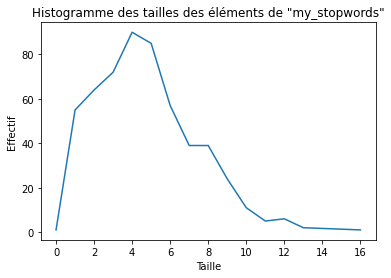

In [185]:
def hist_length(elements):
    stop_by_length = {}
    for e in elements:
        if len(e) in stop_by_length:
            stop_by_length[len(e)].append(e)
        else:
            stop_by_length[len(e)] = [e]
    sorted_tuples = sorted([(t,len(u)) for (t,u) in list(stop_by_length.items())], key = lambda x : x[0])
    plt.plot([x[0] for x in sorted_tuples],[x[1] for x in sorted_tuples])
    plt.title('Histogramme des tailles des éléments de "my_stopwords"')
    plt.xlabel("Taille") ; plt.ylabel("Effectif")
    return(stop_by_length)
stopwords_dico = hist_length(my_stopwords)

On n'observe pas de pic très étroit autour d'une taille typique.

Il peut donc être intéréssant d'ordonner les stopwords par taille pour pouvoir les retrouver plus rapidement.

On range les stopwords par taille dans le dictionnaire "stopwords_dico" dont les clefs sont les tailles.

> --> Permet de passer de 2min à 1min10 lorsqu'on applique le lemmatizer sur tout le corpus !



# 4# Tokenization & Lemmatization

In [ ]:
# Exemple d'utilisation de "lemmatizer"
txt = """Ceci est un exemple !"""
tokens_lemma = lemmatizer(txt) # dirons ! dirait
for token in tokens_lemma:
    print([token], "->", [token.lemma_])

In [187]:
# Définition une borne inf acceptable pour la taille des mots
taille_inf = 2

# Creation de la colonne des tokens lemmatisés
data['tokens'] = None

# Lemmatizer les resumes du corpus
len_stopwords = list(stopwords_dico.keys())
for k in tqdm(range(0,data.shape[0])):
    txt = data['textes'][k]
    txt_tokens = []

    tokens_lemma = lemmatizer(txt)
    for token in tokens_lemma:
        lemma_token = str(token.lemma_).strip(" ") # Permet d'enlever les espaces superflus
        u = len(lemma_token)
        if (u >= taille_inf) and (not(u in len_stopwords) or not(lemma_token in stopwords_dico[u])):
            txt_tokens.append(lemma_token)
    data['tokens'][k] = txt_tokens

  0%|          | 0/1536 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1536/1536 [00:55<00:00, 27.86it/s]


In [188]:
# Exemple aléatoire tiré du corpus
ind = np.random.randint(0,data.shape[0]) ; print(ind,"| EAN =",data['EAN'][ind])
print(data['tokens'][ind])

1146 | EAN = 9782130798538
['condition', 'travail', 'globalement', 'aggraver', 'france', 'europe', 'rançon', 'logique', 'gestionnaire', 'mettre', 'œuvre', 'sein', 'organisation', 'souffrance', 'travail', 'changer', 'nature', 'stress', 'harcèlement', 'sexuel', 'moral', 'violence', 'personnel', 'violence', 'externe', 'exercer', 'extérieur', 'entreprise', 'encontre', 'salarié', 'burn-out', 'addiction', 'etc.', 'nouveau', 'mal', 'travail.depuis', 'milieu', 'année', '2000', 'réalité', 'saisir', 'expression', 'risque', 'psychosocial', 'rps', 'recherche', 'intervention', 'situation', 'travail', 'engendrer', 'souffrance', 'permettre', 'émergence', 'concept', 'outil', 'analyser', 'évaluer', 'prévenir', 'risque', 'ouvrage', 'dresse', 'panorama', 'éclairer', 'utile']


In [189]:
# Tests
x = "?" ; u = len(x)
print(not(u in len_stopwords) or not(x in stopwords_dico[u]))
print(stopwords_dico[u])

print("à"=="à") # WTF ça se voit archi pas !!!

False
['b', 'x', 'o', 'ô', 'y', ']', 'p', 'f', '-', 'c', '/', 'q', '»', '_', '%', 'w', '[', 'm', '«', 't', '\\', ' ', 'l', 's', '>', '}', ';', ':', '"', 'k', 'z', '&', '<', 'd', 'e', 'h', 'a', 'i', ',', '`', 'j', 'à', '.', 'v', ')', 'g', '?', 'u', '!', '(', 'n', '{', 'r', '#', 'â']
False


# 5# LDA

### 5.1# Data preparation

> Prepare bi-grams and tri-grams



In [190]:
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


> Prepare objects for LDA gensim implementation

In [191]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [192]:
print(dictionary_LDA)

Dictionary(6298 unique tokens: ['1991', 'aborder', 'absurde', 'aimer_vie', 'autant']...)


### 5.2# Running LDA

In [193]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 9.46 s, sys: 93.3 ms, total: 9.55 s
Wall time: 9.49 s


### 5.3# Looking at topics

In [194]:
# APERCU FORMATE DES TOPICS
for i,topic in lda_model.show_topics(num_topics=num_topics, num_words=20, formatted=True):
    print(str(i)+": "+ topic)
    print()

0: 0.008*"guerre" + 0.005*"droit" + 0.005*"savoir" + 0.003*"livre" + 0.003*"société" + 0.003*"organisation" + 0.003*"face" + 0.003*"marquer" + 0.003*"venir" + 0.003*"mieux" + 0.003*"sexualité" + 0.003*"présent" + 0.003*"j’" + 0.003*"devoir" + 0.003*"royaume" + 0.003*"île" + 0.003*"apprendre" + 0.003*"développement" + 0.003*"mort" + 0.002*"jeu"

1: 0.005*"livre" + 0.005*"philosophie" + 0.004*"passer" + 0.004*"science" + 0.004*"femme" + 0.004*"temps" + 0.004*"société" + 0.004*"vie" + 0.003*"français" + 0.003*"aujourd’hui" + 0.003*"mémoire" + 0.003*"forme" + 0.003*"an" + 0.003*"nature" + 0.003*"devenir" + 0.003*"rendre" + 0.003*"culture" + 0.003*"savoir" + 0.002*"comprendre" + 0.002*"relation"

2: 0.012*"vie" + 0.005*"art" + 0.005*"œuvre" + 0.005*"société" + 0.004*"savoir" + 0.004*"sens" + 0.004*"passer" + 0.004*"époque" + 0.004*"devoir" + 0.003*"jusqu’" + 0.003*"voir" + 0.003*"terme" + 0.003*"langue" + 0.003*"temps" + 0.003*"aujourd’hui" + 0.003*"pratique" + 0.003*"guerre" + 0.003*"philo

In [195]:
# APERCU NON-FORMATE DES TOPICS
lda_topics = lda_model.show_topics(num_topics=num_topics, num_words=20, formatted=False)
for tp in lda_topics:
    tp_words = [wd[0] for wd in tp[1]]
    print("TOPIC {0} :".format(tp[0]+1)," ".join(tp_words))

TOPIC 1 : guerre droit savoir livre société organisation face marquer venir mieux sexualité présent j’ devoir royaume île apprendre développement mort jeu
TOPIC 2 : livre philosophie passer science femme temps société vie français aujourd’hui mémoire forme an nature devenir rendre culture savoir comprendre relation
TOPIC 3 : vie art œuvre société savoir sens passer époque devoir jusqu’ voir terme langue temps aujourd’hui pratique guerre philosophie ville comprendre
TOPIC 4 : france livre récit objet savoir passer droit ouvrage femme public devoir lieu an aujourd’hui nouveau enfant vrai société forme vie
TOPIC 5 : vie nouveau société culture droit animal évolution possible rapport passer travail question leçon france seul falloir mythe social devoir femme
TOPIC 6 : france guerre social société livre savoir français analyse langue forme auteur travail connaître pratique cœur aujourd’hui comprendre esprit propose scientifique
TOPIC 7 : nouveau français temps empire droit devenir fin compr

### 5.4# Allocating topics to documents

In [196]:
print(data.textes.loc[0][:500])

si nous connaissons pierre-gilles de gennes depuis le prix nobel de physique qui lui fut décerné à l'automne 1991, c'est d'abord parce que ce chercheur hors normes a eu à coeur d'expliquer sa démarche et l'objet de ses travaux, visitant écoles, collèges et lycées et se prêtant volontiers au jeu des médias. qui est véritablement « le newton du xxe siècle », une expression qu'il récusait mais qui n'a rien d'absurde si l'on songe à l'impressionnante étendue des domaines qu'il a abordés ? comment s'


In [197]:
lda_model[corpus[0]]

[(17, 0.9964945)]

### 5.5# Predicting topics on unseen documents

In [ ]:
document = '''Federico Chiesa scored Juve goal 10 seconds into the second half.

The Blues have now lost twice in five days - with only one shot on target in total - after a 1-0 home Premier League defeat to Manchester City on Saturday. I felt we were a bit slow and tired, mentally slow in our decision making.

That's why it's a strange one to analyse, boss Tuchel told BT Sport.

This was only the second time European champions Chelsea have lost consecutive games since Tuchel was appointed in January.

We were so good yesterday in training, but not good enough, not free enough today.

I  don't know why, it was the whole team, he added. They were caught out after the restart as Chiesa scored the earliest Champions League second-half goal since at least 2003-04. At this level you cannot concede an easy goal like this in the first seconds of the second half, said Tuchel. When you know what's coming and you have defensive organisation like we have, normally it's always possible to defend it. We got punished for it. We should have been much, much sharper. We should have asked more questions. Juve have now won three games in a row in all competitions, having dropped into the Serie A relegation zone following a shaky start to Max Allegri's second spell in charge. Allegri said: Sailors always find the way out of a storm. Tonight was a good game against the European champions. Technically we could have played better, but we suffered a bit and we missed a couple of counter-attacks. Two games, six points, zero goals conceded, another step towards qualification, a good step forward.'''
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,0,0.20,"0.012*""specie"" + 0.010*""prey"" + 0.007*""act"" + ..."
1,1,0.11,"0.010*""show"" + 0.008*""game"" + 0.007*""another"" ..."
2,2,0.13,"0.006*""first"" + 0.006*""people"" + 0.006*""work"" ..."
3,10,0.09,"0.009*""people"" + 0.006*""government"" + 0.006*""u..."
4,14,0.05,"0.017*""us"" + 0.007*""time"" + 0.006*""first"" + 0...."
5,16,0.18,"0.009*""find"" + 0.008*""light"" + 0.008*""us"" + 0...."
6,17,0.23,"0.010*""idea"" + 0.008*""work"" + 0.008*""link"" + 0..."


# 6# Advanced exploration of LDA results

#### Allocation of topics in all documents

In [ ]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [ ]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [ ]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [ ]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.998307,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.976829,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.948516,0.0,0.0,0.0,0.0,0.050374,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.973611,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.999022,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
# Which document are about topic 14
document_topic.sort_values(14, ascending=False)[14].head(20)

248    0.999238
58     0.999117
256    0.997293
15     0.996791
41     0.993015
244    0.992670
218    0.991441
116    0.973611
170    0.963462
163    0.954762
225    0.913636
66     0.814545
161    0.617485
237    0.365959
16     0.291999
34     0.284299
236    0.281140
167    0.141683
252    0.109801
8      0.087699
Name: 14, dtype: float64

In [ ]:
print(data.articles.loc[91][:1000])

Image caption Brendan Cole was a professional dancer on Strictly Come Dancing for 13 years

Brendan Cole has announced he will not be returning to Strictly Come Dancing.

The professional dancer revealed during a TV interview on Tuesday that the decision was made by the BBC, saying he was "in shock".

"They made an editorial decision not to have me back on the show," he said on ITV's Lorraine.

A spokesman for the BBC One show thanked Cole for "being part of the show since the beginning" and contributing to its success.

'Emotional and raw'

Cole said: "I'm a little bit in shock at the moment.

"I'm quite emotional and a bit raw about it. I am very disappointed. It's an editorial decision. I will never know the ins and outs.

"I have had 15 incredible series on the show, I'm very proud of the whole show, they're a great team."

Media playback is unsupported on your device Media caption In an interview on 16 January, Brendan Cole told 5 live he wanted to return to Stri


#### Looking at the distribution of topics in all documents

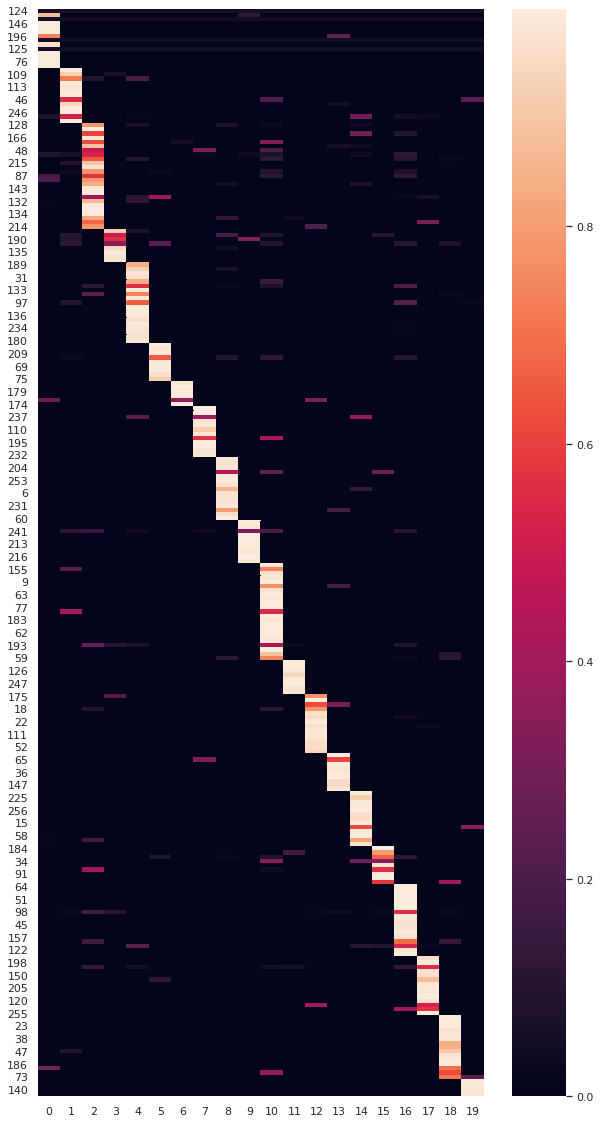

In [ ]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

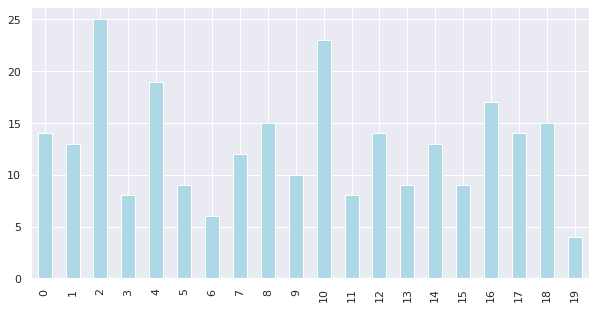

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#### Visualizing topics

In [ ]:
# !pip install pyLDAvis
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
!pip install --upgrade pandas==1.2

     |████████████████████████████████| 9.9 MB 5.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.3
    Uninstalling pandas-1.3.3:
      Successfully uninstalled pandas-1.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.0 which is incompatible.


In [ ]:
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)